In [13]:
from dmsuite import fourdif
import numpy as np 
import matplotlib.pyplot as plt 

The ODE we are trying to solve is, 
$$\alpha n \frac{d n}{d \theta} + (g + U + \alpha D) + (b^2 - 1)(g -D) = - \frac{dn}{d \theta} + n(g + U + \alpha D) $$

The terms that we really care about here are the $b^2$ and $n$ terms. Both beign functions of theta. The rest are treated as constants, whose values are determined experimentally.

This is a non-linear ODE. This is also a boundary value problem with periodic boundary conditions. This ODE presents us with two problems in solving it. 
1. Representing Differentiation on a Discrete Grid 
2. Solving the Non-Linear form of the Equation. 

We use a single cosinusoidal expansion of the magnetic field and de-dimensionalize it  

In [2]:
#Cosinusoidal Expanion
def B(theta):
    epsilon = 1/3
    BB = 1./(1 + epsilon * np.cos(theta))
    return BB

In [3]:
#Dimensionless Magnetic Field Squared
def b2(theta):
    Bs = B(theta)
    dtheta = theta[1]- theta[0]
    fluxavg = np.sum(Bs**2)*dtheta/(2 * np.pi)
    bs = Bs/np.sqrt(fluxavg)
    bsquared = bs**2
    return bsquared

To represent the differentiation operation on our discretized grid we are going to need to take a discrete grid function and turn it into a continuous differentiable one. We will use an interpolating function and the Discrete Fourier Transform to do this.

Technically this is known as a pseudo spectral method using differentiation matrices.

The Discrete Fourier transform takes the form of, 
$$\hat{n}_k = \Delta x \sum_{j = 0}^{N-1}e^{-ikx_j}n_j$$
and the Inverse Discrete Fourier Transform takes the form, 
$$n_j = \frac{1}{2\pi}\sum_{k = -N/2}^{N/2} e^{ikx_j}\hat{n_k}$$

We will make use of the IDFT to construct a Continuous and Differentiable interpolating function for our grid function by evaluating it for all x in the band-limited domain $x \in [\frac{-\pi}{\Delta x}, \frac{\pi}{\Delta x}]$. That is our interpolating function will take the form, 
$$p(x) = \frac{1}{2\pi}\sum_{k = -N/2}^{N/2} e^{ikx}\hat{n_k}$$

First we need a representation of each grid function value globally. To do this we make use of the Kronecker Delta function, $$\delta(k - j) = \left\{\begin{array}{l} \displaystyle \ 1 \quad j = k \\ 0 \quad j \neq k \\ \end{array} \right.$$
And we write each grid function value as, 
$$ n_k = \sum_{j = 0}^{N-1} n_j \delta(k - j)$$

So the Delta function here acts as a sort of sieve and only selects the $n_k$ that we care about. From this representation we compute the fourier transform of the summation representation of the $n_k$ noting that each n_j is a constant and therefore can be factored from the DFT(DFT is a Linear Opertation) and we are left with computing the DFT of the Kronecker Delta. This is a known Fourier Transform which is just the grid size.
$$\Delta x = x_j - x_{j-1}$$
The inverse DFT of this is also well known and is the periodic sinc function on a uniform grid. 
$$S_N(x - x_k) = 
\frac{\sin(\frac{\pi x - x_k}{\Delta x})}{\frac{2\pi}{\Delta x}\tan(\frac{x - x_k}{2})}$$ 
Which acts as an interpolant of the Kronecker Delta function. That is, 
$$    S_N(x - x_k) = \left\{\begin{array}{l}
    1 \quad x = x_k \\
    0 \quad x = x_j, j \neq k
    \end{array}\right.$$
Thus our interpolating function is, 
 $$p(x) = \sum_{j = 0}^{N-1} n_j S_N(x - x_k), \quad x \in [\frac{-\pi}{\Delta x}, \frac{\pi}{\Delta x}]$$
 
 This being a continous and differentiable function with a nice matrix vector representation.
 $$\begin{pmatrix} S_N(x_0 - x_0) &&\dots && S_N(x_0 - x_{N-1})\\
 \vdots && \ddots && \vdots \\
 S_N(x_0 - x_{N-1}) && \dots && S_N(x_{N-1} - x_{N-1})
 \end{pmatrix} \begin{pmatrix}
 n_0 \\
 \vdots \\
 n_{N-1}
 \end{pmatrix}$$

 By differentiating the matrix of sinc functions at the grid points we can derive our differentiation matrix. Whose entries turn out to be, 
 $$ (\mathbf{D}^{(1)})_{ij} = \left\{\begin{array}{l}
    0 \quad i = j \\
    \frac{1}{2}(-1)^{i + j}\cot(\frac{x_j - x_i}{2}) \quad i \neq j
    \end{array}\right.$$
This is what we will use our differentiation operator in our code. Provided to us by the DMSuite package.

An illustrative example of the function of the differnetiation matrix below with a basic sin function. We will compare the differentiation matrix version of the derivative and the analytic derivative $\cos(x)$

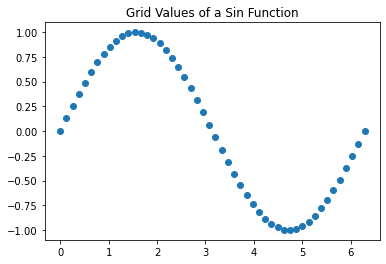

In [23]:
x = np.linspace(0, 2*np.pi)
y = np.sin(x)
plt.title("Grid Values of a Sin Function")
plt.scatter(x, y)
plt.show()

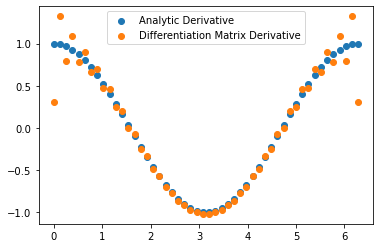

In [26]:
_, ddx= fourdif(50, 1)
y_prime1 = np.cos(x)
y_prime2 =  ddx@ y
plt.scatter(x, y_prime1, label="Analytic Derivative")
plt.scatter(x, y_prime2, label="Differentiation Matrix Derivative")
plt.legend()
plt.show()

Now solving the linear version of this ODE is pretty easy.
 $$ (1 + \alpha)\frac{\partial n}{\partial \theta} = (n-1)(g + U + \alpha D) + (1 - b^2)(g - D)$$

Expanding out and factoring the n's on one side we get, 
$$n[-\frac{d}{d \theta} + (g + U + \alpha D)] = (g + U + \alpha D) + (b^2-1)(g - D)$$
Which we can represent as a Linear System and solve through matrix inversion. As is done below.

In [15]:
def linear(N, U, g, D, alpha, lin = True):
    #Linearized Solution  
    theta, ddtheta = fourdif(N, 1)
    dtheta = theta[1] - theta[0]
    bsquared = b2(theta)
    k = g + U + alpha*D
    m = g - D
    A = np.eye(N)
    A *= -k 
    A += (1 + alpha)*ddtheta 
    c =  -k + (1-bsquared)*m
    n = np.linalg.solve(A, c)
    return n, theta 

To solve the non-linear case we employ a fixed point iteration algorithm in which the first step is to compute the Linear solution. In every subsequent step the solution from the previous step is used as the non-linear term in the current step, turning the non-linear ode into a linear one.

In [6]:
def non_linear(N, U, g, D, alpha):
    #Non-linear solution, fixed point iteration 
    theta, ddtheta = fourdif(N, 1)
    dtheta = theta[1] - theta[0]
    bsquared = b2(theta)
    k = g + U + alpha*D
    m = g - D
    A = np.eye(N)
    A *= k  
    A += -ddtheta
    c =  k + (bsquared - 1)*m
    n = np.linalg.solve(A, c)
    n_old = n
    c =  ddtheta @ n_old
    c *= alpha * n_old
    c += k + (bsquared -1)*m
    n = np.linalg.solve(A, c)
    norm = np.linalg.norm(n - n_old)
    iteration = 0
    while norm > 1e-2 and iteration < 1000:
        n_old = n
        c = ddtheta @ n_old
        c *= alpha*n_old
        c += k + (bsquared - 1)*m
        n = np.linalg.solve(A, c)
        iteration += 1
        norm = np.linalg.norm(n - n_old)
    return n, theta
    

In [7]:
#Some Physics Parameters
Us = [-2.5, -2.1, -1.6]
gs = [1.5, 0, 3.]
alpha = .25
N = 30 
colors = ['cyan', 'magenta', 'green']
D = np.linspace(0,3)

In [8]:
import os as os 
os.getcwd()

'/home/carpfire'

0.002758809224062446
0.04059227599615749
0.0398223512716255


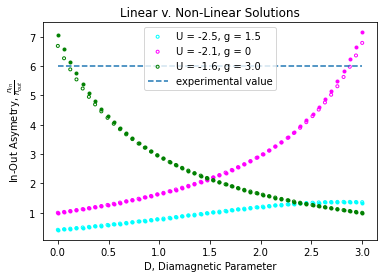

In [14]:
for U, g, c in zip(Us, gs, colors):
    in_out_lin = []
    in_out_nlin = []
    for d in D:
        n, theta = linear(N, U, g, d, alpha)
        nn, _ = non_linear(N, U, g, d, alpha,)
        in_out_lin.append(n[int(N/2)]/n[0]) 
        in_out_nlin.append(nn[int(N/2)]/nn[0])
    print(np.abs(np.mean(np.array(in_out_nlin) - np.array(in_out_lin))))
    plt.title("Linear v. Non-Linear Solutions")
    plt.ylabel(r'In-Out Asymetry, $\frac{n_{in}}{n_{out}}$')
    plt.xlabel("D, Diamagnetic Parameter")
    plt.scatter(D, in_out_lin, s = 9, color = 'none', edgecolor = c, label = f'U = {U}, g = {g}')
    plt.scatter(D, in_out_nlin, c=c, s = 9)
plt.hlines(6,0, 3.0, linestyle = 'dashed', label = "experimental value" )
plt.legend()
#plt.savefig(os.getcwd() +"\Presentation\in_out_assymetry.png")
plt.show()

The Linear and Non-Linear Solutions here are obviously very close to each other. Diverging more when the impurity density in-out asymmetry gets very large. 

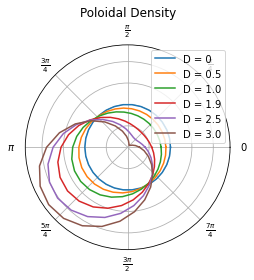

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_yticklabels([])
plt.title("Poloidal Density")
Ds = [0, .5, 1., 1.9, 2.5, 3.0]
for d in Ds:
   # n, theta = non_linear(30, -2.1, 0, d, .25)
    nn, theta = linear(30, -2.1, 0, d, .25)
    #n = np.append(n, n[0])
    nn = np.append(nn, nn[0])
    theta = np.append(theta, theta[0])
    #plt.polar(theta, n)
    plt.polar(theta, nn, label = f'D = {d}')
xT=plt.xticks()[0]
xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
plt.xticks(xT, xL)
plt.legend()
plt.tight_layout()
#plt.savefig(os.getcwd()+"\Presentation\polar_plot.png")
plt.show()